# Deep Learning Prediction Workflow
Predict daily household electricity consumption from weather + recent usage.
Trains three sequence models (LSTM, GRU, temporal CNN), visualizes performance, and saves artifacts.


In [1]:
%pip install -q torch pandas scikit-learn==1.6.1 matplotlib seaborn joblib kaggle holidays
# Uncomment above if your environment is missing dependencies


In [2]:
import os
import subprocess
from pathlib import Path

GITHUB_URL = "https://github.com/HolikGellert/Projektmunka.git"
REPO_PATH = "/content/Projektmunka"

print("Setting up repository from GitHub...")

if not os.path.exists(REPO_PATH):
    # Clone if it doesn't exist
    print(f"Cloning from {GITHUB_URL}...")
    subprocess.run(["git", "clone", GITHUB_URL, REPO_PATH], check=True)
    print(f"✓ Cloned to {REPO_PATH}")
else:
    # Pull latest changes if it already exists
    print(f"Repository already exists at {REPO_PATH}")
    print("Pulling latest changes...")
    subprocess.run(["git", "-C", REPO_PATH, "pull"], check=True)
    print("✓ Pulled latest changes")

# Verify the structure
print(f'\n=== Repo structure ===')
repo_root = Path(REPO_PATH)

# Find prediction/ directory
prediction_dir = repo_root / 'prediction'
if prediction_dir.is_dir():
    print(f'✓ Found prediction/ at {prediction_dir}')
    print(f'  Config: {(prediction_dir / "config.py").is_file()}')
    print(f'  src/: {(prediction_dir / "src").is_dir()}')
else:
    # Search recursively
    found = False
    for root, dirs, files in os.walk(REPO_PATH):
        if 'prediction' in dirs:
            print(f'✓ Found prediction/ at {root}/prediction')
            found = True
            break
    if not found:
        print('✗ prediction/ directory not found')

Setting up repository from GitHub...
Cloning from https://github.com/HolikGellert/Projektmunka.git...
✓ Cloned to /content/Projektmunka

=== Repo structure ===
✓ Found prediction/ at /content/Projektmunka/prediction
  Config: True
  src/: True


In [3]:
import sys
import os
from pathlib import Path

# Search for prediction/ directory starting from /content
REPO_ROOT = None

# Check multiple possible locations
search_paths = [
    Path('/content/Projektmunka'),
    Path('/content/Projektmunka/Projektmunka'),
    Path('/content'),
]

print('Searching for prediction/ directory...')
for search_path in search_paths:
    if search_path.exists():
        print(f'  Checking {search_path}...', end=' ')
        if (search_path / 'prediction').is_dir():
            REPO_ROOT = search_path
            print('✓ Found!')
            break
        else:
            print('✗')

if REPO_ROOT is None:
    # List what's actually in /content
    print('\n✗ Could not find prediction/ directory')
    print('\nContents of /content:')
    if Path('/content').exists():
        for item in os.listdir('/content'):
            item_path = Path('/content') / item
            marker = '📁' if item_path.is_dir() else '📄'
            print(f'  {marker} {item}')
    raise RuntimeError(
        'prediction/ directory not found.\n'
        'The Git clone may have created a different structure.\n'
        'Check the output above to see what was actually cloned.'
    )

print(f'\n✓ Repo root: {REPO_ROOT}')
print(f'✓ Prediction dir: {(REPO_ROOT / "prediction").is_dir()}')
print(f'✓ Config file: {(REPO_ROOT / "prediction" / "config.py").is_file()}')

# Add to sys.path
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
print(f'✓ CUDA available: {torch.cuda.is_available()}')

Searching for prediction/ directory...
  Checking /content/Projektmunka... ✓ Found!

✓ Repo root: /content/Projektmunka
✓ Prediction dir: True
✓ Config file: True
✓ CUDA available: True


In [4]:
import subprocess
from pathlib import Path
import shutil

print('=== Setting up data from GitHub LFS ===\n')

# Ensure Git LFS is available
print('Checking for Git LFS...')
try:
    result = subprocess.run(['git', 'lfs', '--version'], capture_output=True, text=True)
    print(f'✓ {result.stdout.strip()}')
except FileNotFoundError:
    print('⚠ Git LFS not found. Installing...')
    subprocess.run(['apt-get', 'update'], capture_output=True)
    subprocess.run(['apt-get', 'install', '-y', 'git-lfs'], capture_output=True)
    subprocess.run(['git', 'lfs', 'install'], check=True)
    print('✓ Git LFS installed')

# Pull LFS files from the cloned repo
repo_root = Path('/content/Projektmunka')
print(f'\nPulling LFS files from {repo_root}...')

try:
    subprocess.run(['git', '-C', str(repo_root), 'lfs', 'pull'],
                   capture_output=True, text=True, timeout=120, check=True)
    print('✓ Git LFS pull completed')
except subprocess.CalledProcessError as e:
    print(f'⚠ Git LFS pull warning: {e.stderr}')
    print('  Attempting to continue anyway...')

# Look for CSV files in the cloned repo
print('\n=== Looking for CSV files in repo ===')
search_dirs = [
    repo_root / 'prediction' / 'data',
    repo_root / 'data' / 'raw',
    repo_root / 'data',
]

found_daily = None
found_weather = None

for search_dir in search_dirs:
    if search_dir.exists():
        daily_f = search_dir / 'daily_dataset.csv'
        weather_f = search_dir / 'london_weather.csv'
        if daily_f.exists():
            found_daily = daily_f
            print(f'✓ Found daily_dataset.csv in {search_dir.relative_to(repo_root)}')
        if weather_f.exists():
            found_weather = weather_f
            print(f'✓ Found london_weather.csv in {search_dir.relative_to(repo_root)}')

if found_daily is None or found_weather is None:
    print('\n✗ Could not find CSV files')
    print('Missing:')
    if found_daily is None:
        print('  - daily_dataset.csv')
    if found_weather is None:
        print('  - london_weather.csv')
    raise FileNotFoundError('CSV files not found in GitHub repo')

# Copy to working directory
print('\n=== Copying to working directory ===')
data_dir = repo_root / 'prediction' / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

for src_file in [found_daily, found_weather]:
    if src_file and src_file.exists():
        dst_file = data_dir / src_file.name
        # Only copy if not already in the target location
        if str(src_file) != str(dst_file):
            shutil.copy2(str(src_file), str(dst_file))
            print(f'✓ Copied {src_file.name}')
        else:
            print(f'✓ {src_file.name} already in place')
        size_mb = dst_file.stat().st_size / (1024**2)
        print(f'  Size: {size_mb:.1f} MB')

print('\n✓ Data setup complete!')


=== Setting up data from GitHub LFS ===

Checking for Git LFS...
✓ git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

Pulling LFS files from /content/Projektmunka...
✓ Git LFS pull completed

=== Looking for CSV files in repo ===
✓ Found daily_dataset.csv in data/raw
✓ Found london_weather.csv in data/raw

=== Copying to working directory ===
✓ Copied daily_dataset.csv
  Size: 97.3 MB
✓ Copied london_weather.csv
  Size: 0.8 MB

✓ Data setup complete!


In [5]:
# Mount Google Drive (Colab) and define checkpoint/final directories
from pathlib import Path
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

DRIVE_ROOT = Path('/content/drive/MyDrive/Projektmunka')
CHECKPOINT_DIR = DRIVE_ROOT / 'checkpoints'
FINAL_MODEL_DIR = DRIVE_ROOT / 'models'

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print('Drive mounted. Checkpoints ->', CHECKPOINT_DIR)
else:
    print('Not running in Colab; Drive mount skipped.')


Mounted at /content/drive
Drive mounted. Checkpoints -> /content/drive/MyDrive/Projektmunka/checkpoints


## Data prep
Merge energy + weather, add temporal features, scale, and build sliding-window sequences for the models.


In [6]:
from prediction.config import PredictionConfig as Config
from prediction.src.data_prep import PredictionDataPrep

prep = PredictionDataPrep()
merged_df = prep.add_features(prep.load_raw())
seq_data = prep.build_sequences(merged_df)

# Chronological split; scaler is fit on train sequences inside the split helper
X_train, X_val, X_test, y_train, y_val, y_test = prep.train_val_test_split(seq_data)

print('Merged shape:', merged_df.shape)
print('Sequence tensor:', seq_data.X.shape)
print('Train/Val/Test:', X_train.shape, X_val.shape, X_test.shape)
print('Scaler fitted on train split:', seq_data.scaler is not None)


Merged shape: (3468500, 26)
Sequence tensor: (3351789, 21, 16)
Train/Val/Test: (2681433, 21, 16) (335178, 21, 16) (335178, 21, 16)
Scaler fitted on train split: True


## Build dataloaders
Splits sequences into train/validation sets.


In [7]:
from prediction.src.train_utils import create_dataloaders, save_scaler, make_loader

train_loader, val_loader = create_dataloaders(X_train, y_train, X_val, y_val, batch_size=Config.BATCH_SIZE)
test_loader = make_loader(X_test, y_test, batch_size=Config.BATCH_SIZE, shuffle=False)

# Persist the scaler fitted on the training split for consistent inference
assert seq_data.scaler is not None, 'Scaler should be set after splitting'
save_scaler(seq_data.scaler)
len(train_loader), len(val_loader), len(test_loader)


(10475, 1310, 1310)

## Train models
Train an LSTM, GRU, and temporal CNN; log histories and persist weights.


In [8]:
from prediction.src.models import LSTMRegressor, GRURegressor, TemporalCNNRegressor
from prediction.src.train_utils import train_model, save_model, save_metadata, evaluate_mae
import torch

input_size = len(seq_data.feature_cols)
models = {
    'lstm': (LSTMRegressor(input_size=input_size), Config.LSTM_MODEL_PATH),
    'gru': (GRURegressor(input_size=input_size), Config.GRU_MODEL_PATH),
    'tcn': (TemporalCNNRegressor(input_size=input_size), Config.CNN_MODEL_PATH),
}

def save_checkpoint(name, model, epoch):
    if not IN_COLAB:
        return
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    ckpt_path = CHECKPOINT_DIR / f'{name}_checkpoint.pt'
    state = {k: (v.cpu() if torch.is_tensor(v) else v) for k, v in model.state_dict().items()}
    torch.save({'model_state': state, 'epoch': epoch}, ckpt_path)
    print(f"[CKPT] Saved {ckpt_path} at epoch {epoch}")

def load_checkpoint_if_exists(name, model):
    ckpt_path = CHECKPOINT_DIR / f'{name}_checkpoint.pt'
    if IN_COLAB and ckpt_path.exists():
        state = torch.load(ckpt_path, map_location=torch.device('cpu'))
        model.load_state_dict(state.get('model_state', state))
        start_epoch = int(state.get('epoch', 0))
        print(f"[CKPT] Resumed {name} from epoch {start_epoch}")
        return model, start_epoch, ckpt_path
    return model, 0, ckpt_path

histories = {}
metrics = {}

for name, (model, path) in models.items():
    model, start_epoch, ckpt_path = load_checkpoint_if_exists(name, model)
    epochs_remaining = max(Config.EPOCHS - start_epoch, 0)
    if epochs_remaining == 0:
        print(f"{name} already trained for {start_epoch} epochs; skipping training run.")
        history = {'train_loss': [], 'val_loss': []}
    else:
        def _checkpoint_cb(epoch, m=model, nm=name):
            if epoch % 10 == 0:
                save_checkpoint(nm, m, epoch)

        history = train_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs_remaining,
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY,
            grad_clip=Config.GRAD_CLIP,
            max_batches=Config.MAX_TRAIN_BATCHES,
            early_stop_patience=Config.EARLY_STOP_PATIENCE,
            start_epoch=start_epoch,
            checkpoint_fn=_checkpoint_cb if IN_COLAB else None,
        )
    val_mae = evaluate_mae(model, val_loader, max_batches=Config.MAX_EVAL_BATCHES)
    test_mae = evaluate_mae(model, test_loader, max_batches=Config.MAX_EVAL_BATCHES)

    # Save final artifacts: Drive (final) and repo-local copy
    if IN_COLAB:
        FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
        final_path = FINAL_MODEL_DIR / f'{name}_final.pt'
        save_model(model, final_path)
        if ckpt_path.exists():
            ckpt_path.unlink()
            print(f"[CKPT] Removed {ckpt_path} after saving final model.")
    save_model(model, path)

    histories[name] = history
    metrics[name] = {'val_mae': val_mae, 'test_mae': test_mae}

metadata = {
    'feature_cols': seq_data.feature_cols,
    'lookback': seq_data.lookback,
    'metrics': metrics,
}
save_metadata(metadata)
metrics


Epoch 1 - train_loss=12.5635 val_loss=10.7314
Epoch 2 - train_loss=10.9710 val_loss=10.8319
Epoch 3 - train_loss=10.7515 val_loss=10.4495
Epoch 4 - train_loss=10.5951 val_loss=10.6113
Epoch 5 - train_loss=10.5673 val_loss=10.4521
Epoch 6 - train_loss=10.4763 val_loss=10.3108
Epoch 7 - train_loss=10.4413 val_loss=10.3831
Epoch 8 - train_loss=10.4260 val_loss=10.2806
Epoch 9 - train_loss=10.3820 val_loss=10.4522
Epoch 10 - train_loss=10.3265 val_loss=10.1693
[CKPT] Saved /content/drive/MyDrive/Projektmunka/checkpoints/lstm_checkpoint.pt at epoch 10
Epoch 11 - train_loss=10.2921 val_loss=10.2082
Epoch 12 - train_loss=10.2847 val_loss=10.3492
Epoch 13 - train_loss=10.2661 val_loss=10.1771
Epoch 14 - train_loss=10.2802 val_loss=10.1342
Epoch 15 - train_loss=10.2305 val_loss=10.1121
Epoch 16 - train_loss=10.2422 val_loss=10.2254
Epoch 17 - train_loss=10.2098 val_loss=10.3199
Epoch 18 - train_loss=10.2249 val_loss=10.1274
Epoch 19 - train_loss=10.1927 val_loss=10.2311
Epoch 20 - train_loss=10

{'lstm': {'val_mae': 1.7967212200164795, 'test_mae': 1.8908253908157349},
 'gru': {'val_mae': 1.7807821035385132, 'test_mae': 1.8798922300338745},
 'tcn': {'val_mae': 2.2245328426361084, 'test_mae': 2.3312134742736816}}

## Plot training curves


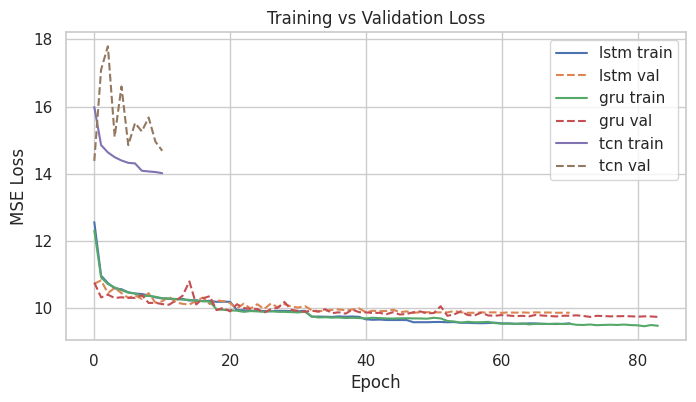

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
for name, hist in histories.items():
    ax.plot(hist['train_loss'], label=f'{name} train')
    ax.plot(hist['val_loss'], linestyle='--', label=f'{name} val')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_title('Training vs Validation Loss')
plt.show()


## Inspect predictions
Visual sanity check on a validation batch.


Model device: cuda:0


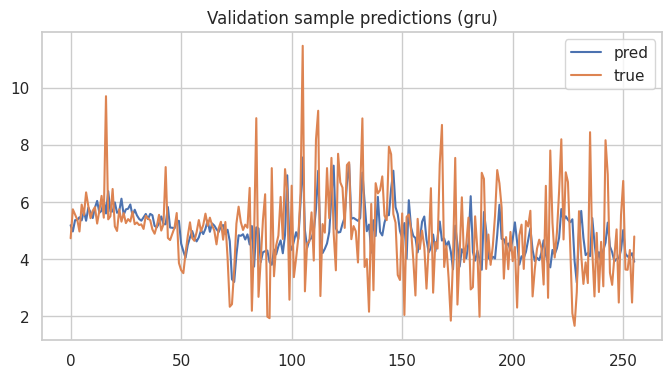

In [10]:
# Choose best model based on validation MAE and visualize a batch
model_key = min(metrics, key=lambda k: metrics[k]['val_mae'])
best_model = models[model_key][0]
best_model.eval()

# Get device from model
device = next(best_model.parameters()).device
print(f'Model device: {device}')

batch_X, batch_y = next(iter(val_loader))
# Move batch to same device as model
batch_X = batch_X.to(device)
batch_y = batch_y.to(device)

with torch.no_grad():
    preds = best_model(batch_X).squeeze().cpu().numpy()
truth = batch_y.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(preds, label='pred')
plt.plot(truth, label='true')
plt.title(f'Validation sample predictions ({model_key})')
plt.legend()
plt.show()


## Inspect test predictions
Quick visual check of the best model on a test batch.


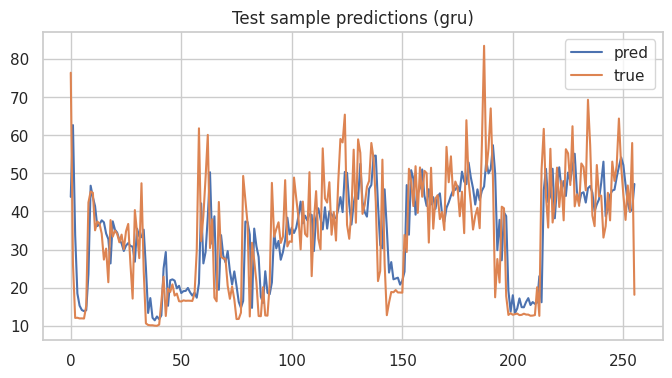

In [11]:
# Visualize a batch from the held-out test set
batch_X_test, batch_y_test = next(iter(test_loader))
batch_X_test = batch_X_test.to(device)
batch_y_test = batch_y_test.to(device)

with torch.no_grad():
    test_preds = best_model(batch_X_test).squeeze().cpu().numpy()
test_truth = batch_y_test.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(test_preds, label='pred')
plt.plot(test_truth, label='true')
plt.title(f'Test sample predictions ({model_key})')
plt.legend()
plt.show()


## LSTM-only plot from saved weights
Generate pred vs true without retraining (loads saved LSTM model).

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


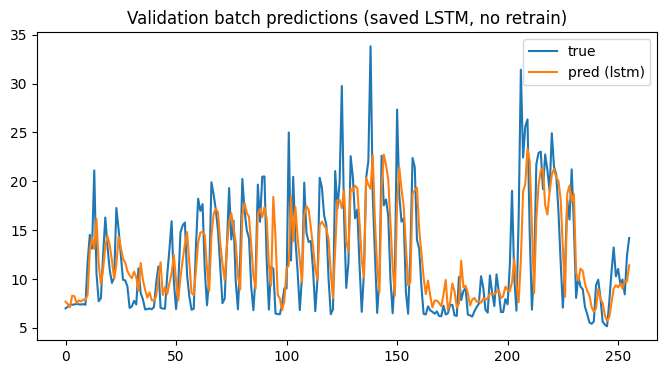

In [8]:
import sys
from pathlib import Path
import torch
import joblib
import matplotlib.pyplot as plt

# Locate repo root containing prediction/
CANDIDATES = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/content/Projektmunka'),
    Path('/Users/leibi/Projektmunka/Projektmunka'),
]
repo_root = None
for cand in CANDIDATES:
    if (cand / 'prediction').is_dir():
        repo_root = cand
        sys.path.insert(0, str(cand))
        break
if repo_root is None:
    raise ModuleNotFoundError('prediction package not found; please set repo_root manually')

from prediction.config import PredictionConfig as Config
from prediction.src.models import LSTMRegressor
from prediction.src.data_prep import PredictionDataPrep
from prediction.src.train_utils import make_loader

# Build sequences and scaler
prep = PredictionDataPrep()
merged = prep.add_features(prep.load_raw())
seq_data = prep.build_sequences(merged)
X, y = seq_data.X, seq_data.y
cap = 20000
if len(X) > cap:
    X = X[:cap]; y = y[:cap]
scaler = joblib.load(Config.SCALER_PATH)
shape = X.shape
X_scaled = scaler.transform(X.reshape(-1, shape[-1])).reshape(shape)
n = len(X_scaled); tst = int(n * Config.TEST_RATIO); val = int(n * Config.VAL_RATIO)
train_end = n - tst - val; val_end = n - tst
X_val, y_val = X_scaled[train_end:val_end], y[train_end:val_end]
val_loader = make_loader(X_val, y_val, batch_size=Config.BATCH_SIZE, shuffle=False)

# Load LSTM and plot
lstm = LSTMRegressor(input_size=X.shape[-1])
state = torch.load(Config.LSTM_MODEL_PATH, map_location=torch.device('cpu'))
lstm.load_state_dict(state)
lstm.eval()

batch_X, batch_y = next(iter(val_loader))
with torch.no_grad():
    preds = lstm(batch_X).squeeze().cpu().numpy()
truth = batch_y.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(truth, label='true')
plt.plot(preds, label='pred (lstm)')
plt.title('Validation batch predictions (saved LSTM, no retrain)')
plt.legend()
plt.show()


## Saved LSTM quick plots (no retrain)
Pred vs true, scatter, error hist, single-household trace, and energy_sum distribution.

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


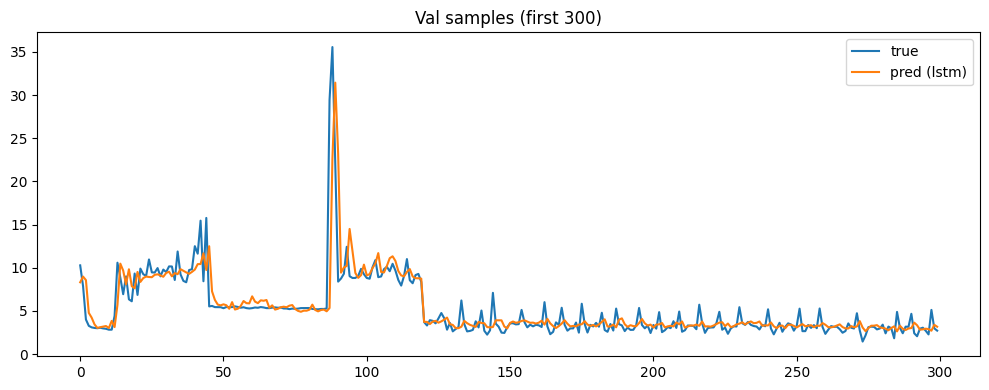

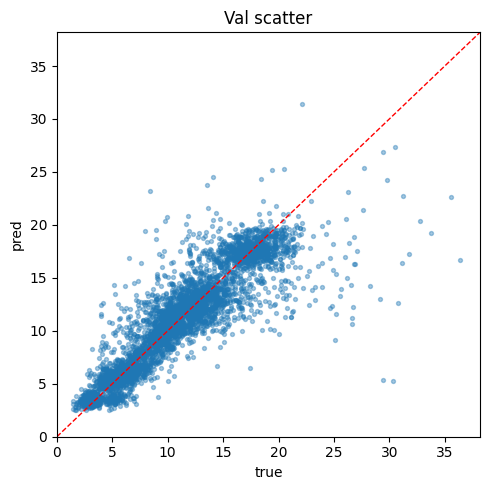

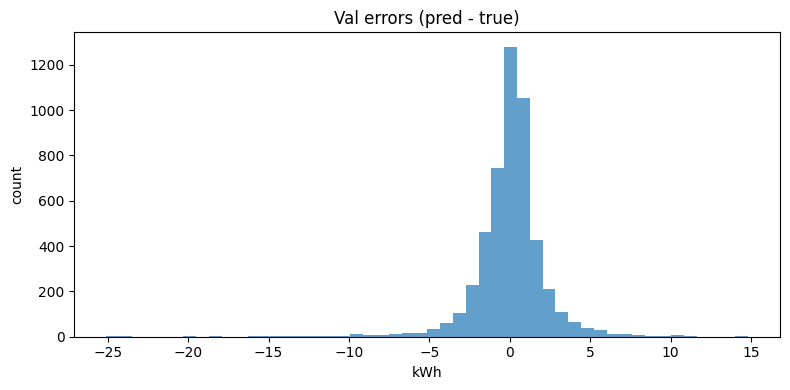

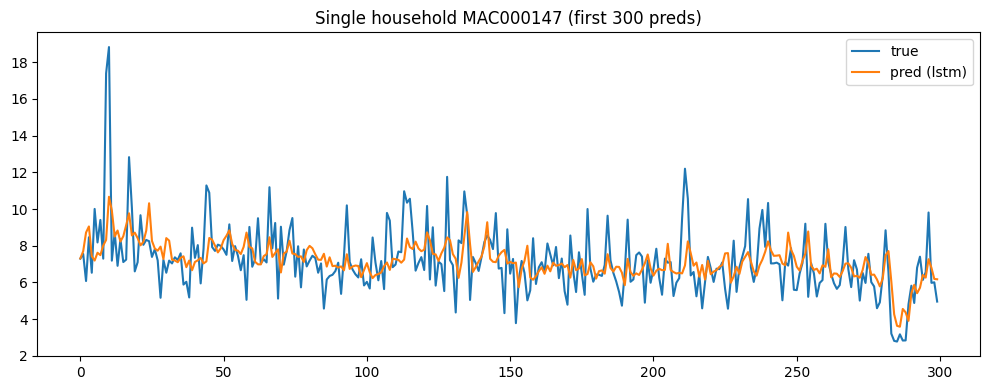

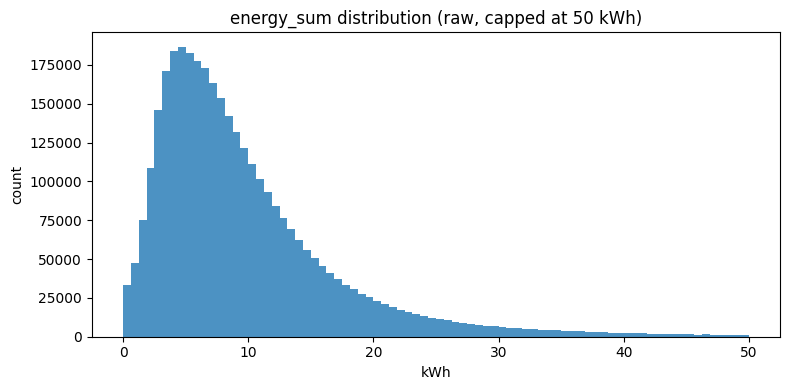

In [9]:
import sys, json
from pathlib import Path
import torch, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Locate repo root containing prediction/
CANDIDATES = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/content/Projektmunka'),
    Path('/Users/leibi/Projektmunka/Projektmunka'),
]
repo_root = None
for cand in CANDIDATES:
    if (cand / 'prediction').is_dir():
        repo_root = cand
        sys.path.insert(0, str(cand))
        break
if repo_root is None:
    raise ModuleNotFoundError('prediction package not found; please set repo_root manually')

from prediction.config import PredictionConfig as Config
from prediction.src.models import LSTMRegressor
from prediction.src.data_prep import PredictionDataPrep
from prediction.src.train_utils import make_loader

prep = PredictionDataPrep()
merged = prep.add_features(prep.load_raw())
seq_data = prep.build_sequences(merged)
X, y = seq_data.X, seq_data.y
cap = 50000
if len(X) > cap:
    X = X[:cap]; y = y[:cap]

scaler = joblib.load(Config.SCALER_PATH)
shape = X.shape
X_scaled = scaler.transform(X.reshape(-1, shape[-1])).reshape(shape)
n = len(X_scaled); tst = int(n * Config.TEST_RATIO); val = int(n * Config.VAL_RATIO)
train_end = n - tst - val; val_end = n - tst
X_val, y_val = X_scaled[train_end:val_end], y[train_end:val_end]

lstm = LSTMRegressor(input_size=X.shape[-1])
state = torch.load(Config.LSTM_MODEL_PATH, map_location=torch.device('cpu'))
lstm.load_state_dict(state); lstm.eval()

val_loader = make_loader(X_val, y_val, batch_size=Config.BATCH_SIZE, shuffle=False)
preds_list, truth_list = [], []
with torch.no_grad():
    for bx, by in val_loader:
        p = lstm(bx).squeeze().cpu().numpy()
        preds_list.append(p)
        truth_list.append(by.squeeze().cpu().numpy())
val_preds = np.concatenate(preds_list)
val_truth = np.concatenate(truth_list)

# Plot 1: first 300 samples line plot
plt.figure(figsize=(10,4))
plt.plot(val_truth[:300], label='true')
plt.plot(val_preds[:300], label='pred (lstm)')
plt.title('Val samples (first 300)')
plt.legend(); plt.tight_layout(); plt.show()

# Plot 2: scatter true vs pred
plt.figure(figsize=(5,5))
plt.scatter(val_truth, val_preds, s=8, alpha=0.4)
lim = (0, float(max(val_truth.max(), val_preds.max())*1.05))
plt.plot(lim, lim, 'r--', linewidth=1)
plt.xlim(lim); plt.ylim(lim)
plt.xlabel('true'); plt.ylabel('pred'); plt.title('Val scatter')
plt.tight_layout(); plt.show()

# Plot 3: error histogram
errors = val_preds - val_truth
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Val errors (pred - true)')
plt.xlabel('kWh'); plt.ylabel('count'); plt.tight_layout(); plt.show()

# Plot 4: single household trace
top_id = merged['LCLid'].value_counts().idxmax()
hh = merged[merged['LCLid']==top_id].sort_values('day')
hh_seq = prep.build_sequences(hh)
Xh, yh = hh_seq.X, hh_seq.y
Xh_scaled = scaler.transform(Xh.reshape(-1, Xh.shape[-1])).reshape(Xh.shape)
with torch.no_grad():
    hh_preds = lstm(torch.tensor(Xh_scaled, dtype=torch.float32)).squeeze().cpu().numpy()
plt.figure(figsize=(10,4))
limit = min(300, len(yh))
plt.plot(yh[:limit], label='true')
plt.plot(hh_preds[:limit], label='pred (lstm)')
plt.title(f'Single household {top_id} (first {limit} preds)')
plt.legend(); plt.tight_layout(); plt.show()

# Plot 5: energy_sum distribution (raw)
plt.figure(figsize=(8,4))
plt.hist(merged['energy_sum'], bins=80, range=(0,50), alpha=0.8)
plt.title('energy_sum distribution (raw, capped at 50 kWh)')
plt.xlabel('kWh'); plt.ylabel('count'); plt.tight_layout(); plt.show()
